In [0]:
#unzipping here in colab session
#!unzip '/content/drive/My Drive/MonuSeg-20200317T123814Z-001.zip'

In [3]:
#!pip install --ignore-installed --upgrade tensorflow==1.14.0
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
#%reset

In [5]:
#Dataset MonuSeg
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

#import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.optimizers import SGD

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [0]:
#%reset

In [0]:
# Set some parameters
im_width = 512
im_height = 512
#border = 5

In [8]:
# list of names all images in the given path
ids_train = next(os.walk("./MonuSeg/Training/TissueImages"))[2]
print("No. of images in training set= ", len(ids_train))

# list of names all images in the given path
ids_test = next(os.walk("./MonuSeg/Test/TissueImages"))[2]
print("No. of images in testing set = ", len(ids_test))

No. of images in training set=  30
No. of images in testing set =  14


In [0]:
#train
X_train = np.zeros((len(ids_train), im_height, im_width, 1), dtype=np.float32)
y_train = np.zeros((len(ids_train), im_height, im_width, 1), dtype=np.float32)

#test
X_test = np.zeros((len(ids_test), im_height, im_width, 1), dtype=np.float32)
y_test = np.zeros((len(ids_test), im_height, im_width, 1), dtype=np.float32)

In [10]:
X_train.shape

(30, 512, 512, 1)

In [11]:
#train

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_train), total=len(ids_train)):
    # Load images
    img = load_img("MonuSeg/Training/TissueImages/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    
    #rename mask
    d = id_.split('.')
    d[0] = d[0]+"_bin_mask."
    id_ = d[0]+d[1]
    #print(id_)
    #renamed becuase GT in filenames include _bin_mask in names
    
    # Load masks
    mask = img_to_array(load_img("MonuSeg/Training/GroundTruth/"+id_, grayscale=True))
    mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Save images
    X_train[n] = x_img/255.0
    y_train[n] = mask/255.0
    
    
    
#test

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_test), total=len(ids_test)):
    # Load images
    img = load_img("MonuSeg/Test/TissueImages/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    
    #rename mask
    d = id_.split('.')
    d[0] = d[0]+"_bin_mask."
    id_ = d[0]+"png"
    #print(id_)
    #renamed becuase GT in filenames include _bin_mask in names
    
    # Load masks
    mask = img_to_array(load_img("MonuSeg/Test/GroundTruth/"+id_, grayscale=True))
    mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Save images
    X_test[n] = x_img/255.0
    y_test[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5
True


Text(0.5, 1.0, 'Mask')

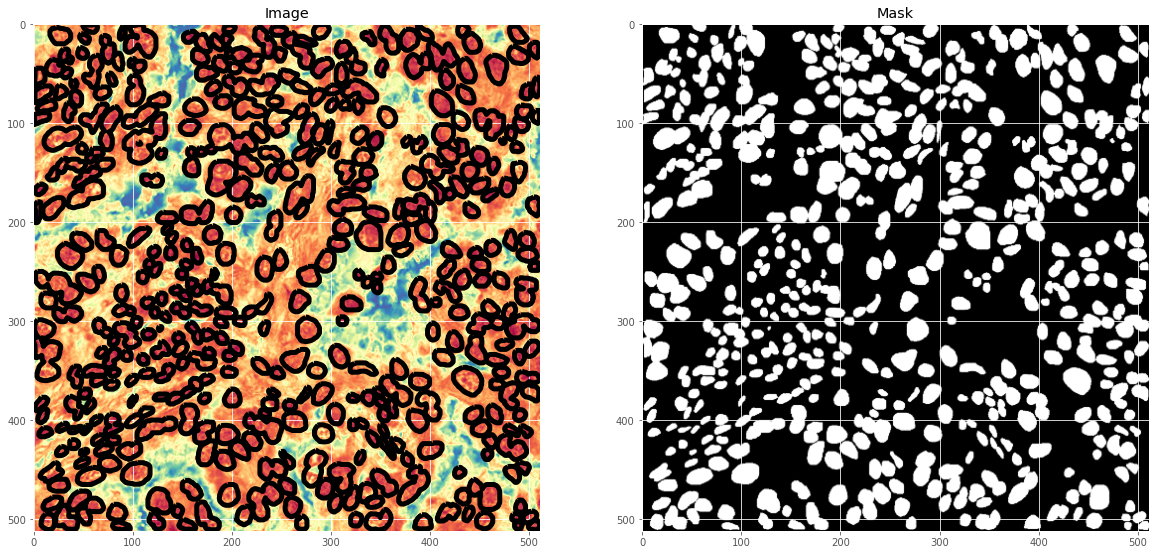

In [12]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
print(ix)
has_mask = y_train[ix].max() > 0 # salt indicator
print(has_mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'Spectral', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Image')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')


In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.01, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
#metrics
import keras.backend as K
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [16]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.01, batchnorm=True)
model.compile(optimizer=SGD(), loss="binary_crossentropy", metrics=["accuracy",dice_coef])

#binary_crossentropy













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 512, 512, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 512, 512, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [0]:
callbacks = [
    #EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.0001, verbose=1),
    ModelCheckpoint('model-monuseg-unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
#!rm /content/model-monuseg-unet.h5

In [21]:
results = model.fit(X_train, y_train, batch_size=4, epochs=200, callbacks=callbacks,
                    validation_data=(X_test, y_test))



Train on 30 samples, validate on 14 samples
Epoch 1/200
30/30 [==============================] - 10s 332ms/step - loss: 0.7389 - acc: 0.4237 - dice_coef: 0.3023 - val_loss: 0.6521 - val_acc: 0.5352 - val_dice_coef: 0.2894

Epoch 00001: val_loss improved from inf to 0.65212, saving model to model-monuseg-unet.h5
Epoch 2/200
30/30 [==============================] - 1s 27ms/step - loss: 0.6358 - acc: 0.5133 - dice_coef: 0.3556 - val_loss: 0.5941 - val_acc: 0.5864 - val_dice_coef: 0.3477

Epoch 00002: val_loss improved from 0.65212 to 0.59407, saving model to model-monuseg-unet.h5
Epoch 3/200
30/30 [==============================] - 1s 28ms/step - loss: 0.5823 - acc: 0.5609 - dice_coef: 0.3874 - val_loss: 0.5586 - val_acc: 0.6114 - val_dice_coef: 0.3846

Epoch 00003: val_loss improved from 0.59407 to 0.55857, saving model to model-monuseg-unet.h5
Epoch 4/200
30/30 [==============================] - 1s 27ms/step - loss: 0.5537 - acc: 0.5815 - dice_coef: 0.4080 - val_loss: 0.5391 - val_acc

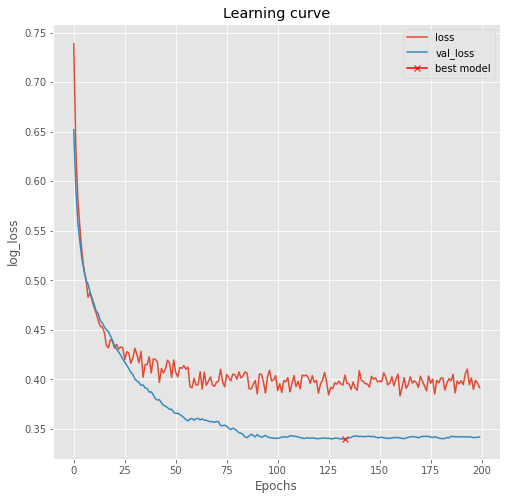

In [22]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

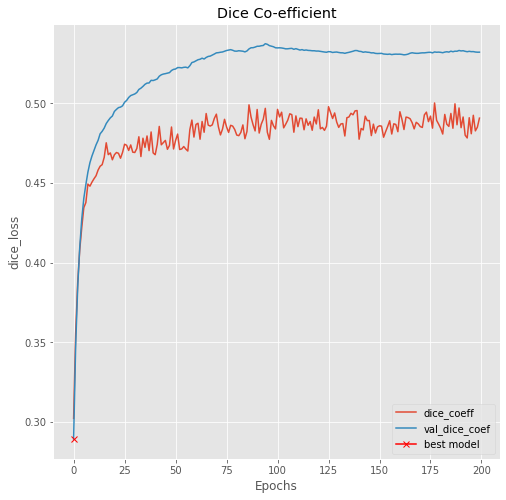

In [23]:
plt.figure(figsize=(8, 8))
plt.title("Dice Co-efficient")
plt.plot(results.history['dice_coef'], label="dice_coeff")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmin(results.history["val_dice_coef"]), np.min(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_loss")
plt.legend();

In [0]:
# load the best model
model.load_weights('model-monuseg-unet.h5')

In [25]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_test, y_test, verbose=1)

14/14 [==============================] - 1s 46ms/step


[0.3396333158016205, 0.7098941802978516, 0.5313133597373962]

In [26]:
# Predict on train, val and test
preds_test = model.predict(X_test, verbose=1)

14/14 [==============================] - 0s 27ms/step


In [0]:
# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('original')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Masks')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

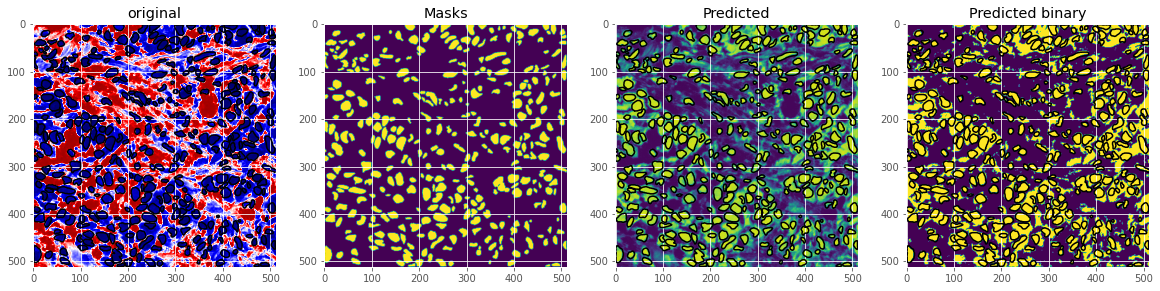

In [30]:
#prediction on test set
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=12)

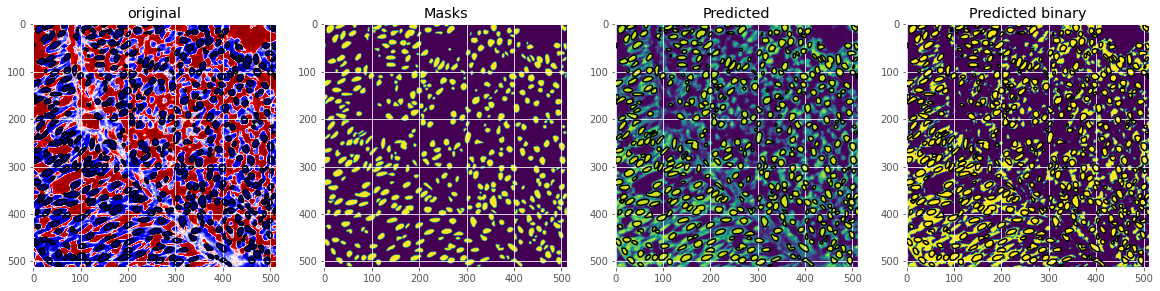

In [32]:
#prediction on test set
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=4)